# ASL Alphabet Recognition with Neural Network

###### Tommaso De Battista (z5209309), Joel Ivory (z5162834), Borumy Kim (z5208668), Rudra Jikadra (z5270484)


## 1A. Problem statement

Society has been forced to keep up with the demand for virtual working environments due to Covid-19. Hence, many people with disabilities including but not limited to deaf and mute people have also been severely impacted. Leveraging advancements in technology, we are all obligated to take measures in order to accommodate the minority in order to create an inclusive online academic/professional environment.

## 1B. Model summary

We have developed an action detection model to decode ASL (American sign language) to build a deep learning neural network leveraging Tensorflow and Keras. The model primarily relies on four LSTM layers to process a sequence of key points on the hand. Hence, as a person communicates through ASL with a webcam, the program then vocalizes the words in real time. 

## 1C. Dependencies

To execute the notebook, ensure that you have a python environment in version 3.8. Within the directory is an included ```requirements.txt``` file which can be pip installed with all the packages utilised within this notebook.

In [2]:
import cv2
import re
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import pyttsx3
import mediapipe as mp  
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.python.client import device_lib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from string import ascii_uppercase

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU'))) # Checks whether there is a GPU available
print(device_lib.list_local_devices()) # Lists the available devices


Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12888217219854108540
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7011009824
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7593514446243075991
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


# 2. Functions & Variables

Functions that were utilised throughout the program and major variables. The ```INPUT_VIDEO_PATH``` variable is where the .mp4 files where stored locally. The primary source for the model and functions within this notebook can be found here: https://github.com/nicknochnack/ActionDetectionforSignLanguage


In [2]:

INPUT_VIDEO_PATH = r'C:\Users\Tommaso\Google Drive\Current Courses\COMP9444\CodingTasks\Data'
SEQUENCE_LENGTH = 30 # How many frames are recorded
VID_SEQUENCES = 90 # No. of videos recorded at a time

mp_holistic = mp.solutions.holistic # bringing the holstic model
mp_drawing = mp.solutions.drawing_utils # drawing utilities
label_map = {} # map of the labels
no_sequences = {} # no. of videos for each action
actions = [] # ASL alphabet gestures

for letter in ascii_uppercase:
    no_sequences[letter] = VID_SEQUENCES

actions = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V' ,'W', 'X', 'Y', 'Z'] 

# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Videos are going to be 30 frames in length
SEQUENCE_LENGTH = 30

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction - detecting using mediapipe
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections
    
# CAN CHANGE THE COLOURS OF THESE TO MAKE IT DIFFERENT 
def draw_styled_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,43,114), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(58,23,200), thickness=2, circle_radius=2)
                             ) 
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(145,45,123), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(160,66,194), thickness=2, circle_radius=2)
                             ) 

# Extracting data points
def extract_keypoints(results):
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([lh, rh])


# 3. Data Sources

When conducting research into possible datasets to utilise, it was difficult to locate a dataset that met the requirements of our project. Most data sources available online were primarily static image datasets such as the MINST ASL Alphabet (https://www.kaggle.com/datasets/datamunge/sign-language-mnist), which did not include dynamic letter gestures such as ‘J’ or ‘Z’. Other available sources such as the American Sign Language Lexicon Video Dataset (http://www.bu.edu/asllrp/av/dai-asllvd.html), were far too large and would have required a large amount of computational power to process, which was not viable given the timeframe of the project. Instead, the dataset was created by the project team, with members acting out each gesture for the ASL Alphabet.


# 3A. Video Dataset Generating 

In order to generate the dataset, first, a person would act out the gesture for 30 frames (dictated by the variable ```SEQUENCE_LENGTH```) which would then be saved and stored locally. 

The .mp4 Dataset: https://drive.google.com/drive/folders/1remaeH8z1JJg2koV2bP4F0GKQ6xUGhBc?usp=sharing



In [6]:
INPUT_VIDEO_PATH = r'C:\Users\Tommaso\Google Drive\Current Courses\COMP9444\CodingTasks\Data1'

cap = cv2.VideoCapture(0)

writer_check = False

# Determine width and height of frame
width= int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height= int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Create directory if it does not exist already
if not os.path.exists(INPUT_VIDEO_PATH):
    os.mkdir(INPUT_VIDEO_PATH)
break_check = False

try:
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        
        # Loop through alphabet
        for action in ascii_uppercase:
            
            # Loop through sequences aka videos
            for sequence in range(VID_SEQUENCES):
                # Loop through video length aka sequence length
                for frame_num in range(SEQUENCE_LENGTH + 1):

                    # Read feed
                    ret, frame = cap.read()

                    # Make detections
                    image, results = mediapipe_detection(frame, holistic)

                    # Draw landmarks
                    draw_styled_landmarks(image, results)
                    
                    # NEW Apply wait logic
                    if frame_num == 0:
                        name = action + '.' + str(sequence).zfill(3) + '.mp4'
                        file_path = os.path.join(INPUT_VIDEO_PATH, name)
                        if not os.path.exists(file_path):
                            writer_check = True
                            cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                            cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                            # Show to screen
                            cv2.imshow('OpenCV Feed', image)
                            cv2.waitKey(2000)
                            writer= cv2.VideoWriter(file_path, cv2.VideoWriter_fourcc(*'DIVX'), 30, (width,height))
                        else:
                            writer_check = False
                            cv2.putText(image, 'DATA ALREADY COLLECTED', (120,200), 
                                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                            cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                            cv2.imshow('OpenCV Feed', image)
                            cv2.waitKey(200)
                            break
                    else: 
                        cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                        # Show to screen
                        cv2.imshow('OpenCV Feed', image)
                        writer.write(frame)

                    # Break gracefully
                    if cv2.waitKey(10) & 0xFF == ord('q'):
                        writer.release()
                        cap.release()
                        cv2.destroyAllWindows()
                        break_check = True 
                        break
            
                if writer_check == True:
                    writer.release() 
                    writer_check = False
            
            if cv2.waitKey(10) & 0xFF == ord('q'):
                writer.release()
                cap.release()
                cv2.destroyAllWindows()
                break_check = True 
                break
                

        writer.release()          
        cap.release()
        cv2.destroyAllWindows()
except cv2.error:
    print("Exited!")

exited


# 4. Numpy Array Data Processing

Once a video was recorded, MediaPipe Holistic would use it to determine the key points of the hand, which it then tracks and records throughout the video. For each frame, the hand key points are stored within a .npy array and saved within the project directory to be utilised later within the model. This process was repeated to create 90 samples (dictated by the variable ```no_sequences```) for each of the 26 classes of letters.

The .npy Dataset: located within the MP_Data folder

In [ ]:
INPUT_VIDEO_PATH = r'C:\Users\Tommaso\Google Drive\Current Courses\COMP9444\CodingTasks\Data' #local location for dataset

label_map = {} # map of the labels
no_sequences = {} # no. of videos for each action
actions = [] # ASL alphabet gestures

i = 0
for j, vid in enumerate(os.listdir(INPUT_VIDEO_PATH)):
    print(vid)
    if '.mp4' in vid:
        string = vid.split('.')
        action = string[0]
        sequence = int(string[1])
        cap = cv2.VideoCapture(vid)
        label_map[action] = i
        
        if action in no_sequences:
            no_sequences[action] += 1
        else:
            no_sequences[action] = 1
        i += 1
        if action not in actions:
            actions.append(action)
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            # Skips the video if the files already exist
            print('Directory Already Exists, passing file')
            continue
            
        vid_loc = os.path.join(INPUT_VIDEO_PATH,vid)
        cap = cv2.VideoCapture(vid_loc)
        # Set mediapipe model 
        with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
            # this is code for reading from a video file
            frame_num = 0
            while(cap.isOpened() and frame_num < SEQUENCE_LENGTH):
                # Read feed
                ret, frame = cap.read()
                
                if ret:
                    image, results = mediapipe_detection(frame, holistic)
                    # Draw landmarks
                    draw_styled_landmarks(image, results)
                    cv2.waitKey(1)
                    
                    # UNCOMMENT THIS TO SEE THE VIDEO DISPLAYED (THIS GREATLY INCREASES THE EXECUTION TIME OF THE PROGRAM)
                    # cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                    #                 cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # # # Show to screen
                    # cv2.imshow('OpenCV Feed', image)
                    
                    # NEW Export keypoints
                    keypoints = extract_keypoints(results)
                    npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                    np.save(npy_path, keypoints)
                    frame_num += 1
                else:
                    break
                
        cap.release()
        cv2.destroyAllWindows()



# 3. Exploratory Data Anaylsis

From the collected .npy files, the data is labelled accordingly based on the letter within the ASL alphabet. The dataset is then split in training and testing dataset.

| Details            | No.    |
|--------------------|--------|
| Classes            | 26     |
| Samples per Class  | 90     |
| Total Samples      | 2340   |
| Video Dataset Size | 1.10GB |
| .npy Dataset Size  | 241MB  |

The data was prepared by first creating a label map for each of the alphabet letters which is stored under ```label_map```. The .npy arrays are then appended to the ```sequence``` array which will store all 2340 videos, each with 30 frames and 126 keypoints, to create the X data for the model. The Y data is then processed through the use of the ```tensorflow.keras.utils.to_categorical``` package which converts the labelled data to a one-hot encoded array. The data is then split 85/15 between training and testing data.

In [9]:
label_map = {label:num for num, label in enumerate(actions)}
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences[action]):
        window = []
        for frame_num in range(SEQUENCE_LENGTH):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

print(label_map)
X = np.array(sequences)
y = to_categorical(labels).astype(int)
print("Sequence shape:", np.array(sequences).shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

{'A': 90, 'B': 90, 'C': 90, 'D': 90, 'E': 90, 'F': 90, 'G': 90, 'H': 90, 'I': 90, 'J': 90, 'K': 90, 'L': 90, 'M': 90, 'N': 90, 'O': 90, 'P': 90, 'Q': 90, 'R': 90, 'S': 90, 'T': 90, 'U': 90, 'V': 90, 'W': 90, 'X': 90, 'Y': 90, 'Z': 90}
['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25}
(2340, 30, 126)


# 4A. Model

We implemented 2 methods one of which was applying a simple Convolution Neural Network on each frame of preprocessed images that goes through binary and otsu thresholding. As this CNN was only trained on and tested on a single image frame, it did not provide optimal results and struggled between multiple alphabet gestures such as "N" and "M". The second model using Google's MediaPipe Library and Long Short-Term Memory (LSTM) Recurrent Neural Network was successfully trained and provided far more consistent results. Using Mediapipe’s holistics combined with the LSTM Layers gave us certain advantages, first the dataset required to successfuly train the model was much smaller in size. Due the network being far denser and not requiring any convultion layers, the trainable paramters were only around 600,000 in comparison to other CNN models which reach up to 30 to 40 million parameters. Overall this meant that the network was far easier to train and predict than other CNN models.

# 4B. Build and Train LSTM Neural Network

The model is defined and trained within this section based on the previously created dataset. ```model.summary()``` provides an outline of the model aswell as some of the hyper parameters. The model consisted of a 6-layer LSTM Neural network that was made up of 4 LSTM layers with a 25% dropout in the first three, followed by 2 dense layers giving a total of 631,226 trainable parameters. The dropouts were included to assist the model in generalising the data and not overfitting, improving its use when predicting with a live video. The model input was a 30 by 126 size array, which is made up of 30 frames of 126 key points (58 key points from each hand). The output for the model was a softmax vector of size 26, which provided a percentage for each of the letters within the alphabet, summing to a total of 100%. The learning rate and epochs for training the model were 0.0001 and 1000 respectively and the metrics used for evaluating the model were categorical accuracy and confusion matrices. The categorical accuracy provided an overall model performance, whereas the confusion matrices provided insight into the performance of each ASL gesture.


In [13]:

print(X.shape)
actions = np.asarray(actions)
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,126)))
model.add(Dropout(0.25))
model.add(LSTM(256, return_sequences=True, activation='relu'))
model.add(Dropout(0.25))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(Dropout(0.25))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.fit(X_train, y_train, epochs=1000, callbacks=[tb_callback])

(2340, 30, 126)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 64)            48896     
_________________________________________________________________
dropout (Dropout)            (None, 30, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 256)           328704    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 128)           197120    
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64) 

# 5. Validating and Predicting the Model

During this section, a prediction is made utilising the model and is compared to the test data to validate whether the model is functioning correctly.

In [18]:
res = model.predict(X_test)
print(actions[np.argmax(res[20])])
print(actions[np.argmax(y_test[20])])

S
S


# 6. Model Evaluation

The accuracy of the model is evaluated based on two criteria, accuracy and a mutlilabel confusion matrix, through the use of the ```sklearn.metrics``` package. Despite working with a significantly smaller dataset than some state-of-the-art models. Our model achieved an accuracy of 98.58%. 

The current state-of-the-art ASL recognition models utilise very large image datasets (namely the MNIST Database), with the most accurate outperforming all existing approaches with an accuracy rate of 99.67% on unseen test data. This CNN-based architecture had over 27000 training cases and over 7000 test cases with further divisions of the dataset for validation. In total, almost 3 million parameters were trained by the model, which is significantly larger than the total of 631,226 parameters trained by our model. However, this state-of-the-art model is not detecting ASL via video frames, which our model has been trained to do.

From the multilabel confusion matrix generated by our model, its accuracy is evidently clear. The model encountered false positives or false negatives when predicting the classes ‘G’, ‘H’, ‘K’, ‘N’ and ‘W’. We believe this to be due to the similarities in the hand signals for those letters. The results of our model could be improved with state-of-the-art hardware that has the capability to train a model that utilises convolutional layers. With the use of better hardware (such as the Leap Motion Controller used in 'Chong & Lee, 2018'), our model may be able to better distinguish between similar hand signals.

Whilst the accuracy of our model is high, it has a few limitations. Firstly, to be considered deployable in real-world applications such as a class on Zoom or a work meeting on Microsoft Teams, our model would need to accurately distinguish each hand sign on unseen data with a variety of backgrounds, hand sizes and skin tones. We noticed that our model had some trouble with certain ASL signs.  Secondly, to be ready for deployment our model would need to be able to detect ASL much faster and in sentences and be aware of when a word starts, ends and ultimately be able to either send this output as a text message in the application to other members or provide this output as a text to speech feature. These are the next steps for our project to reach deployment.

The model has an accuracy of:  0.9857549857549858


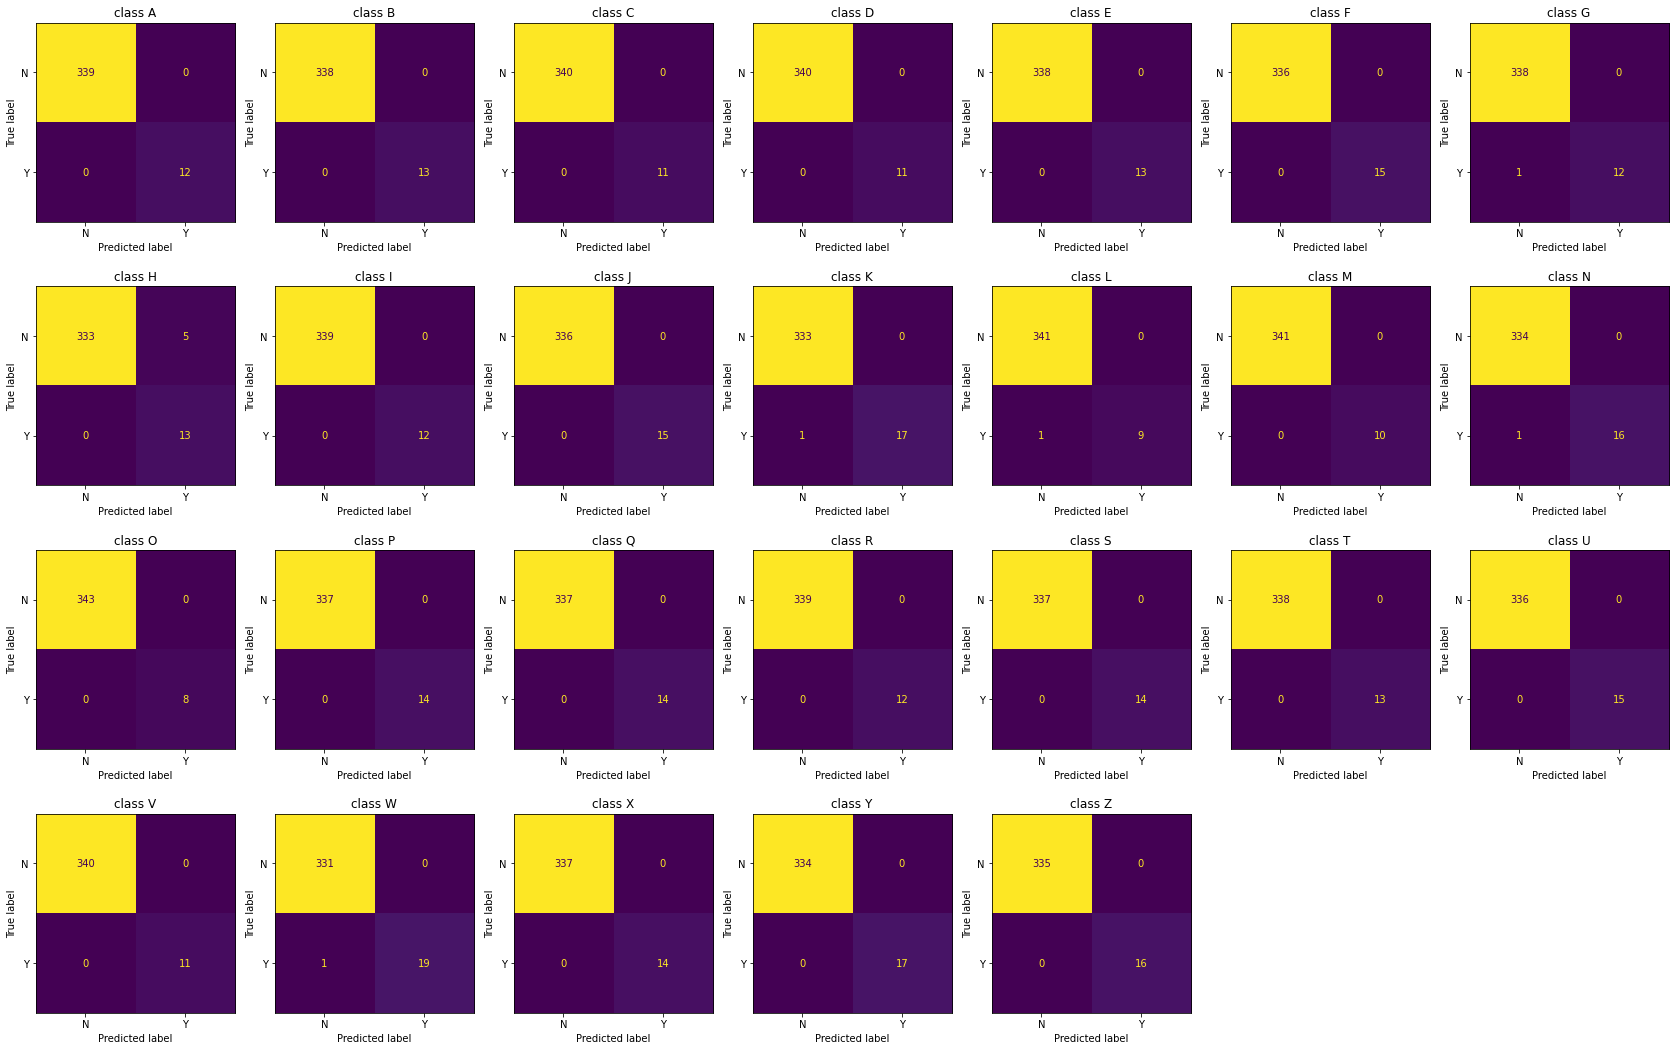

In [17]:
yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
matrix_conf = multilabel_confusion_matrix(ytrue, yhat)
print("The model has an accuracy of: ", accuracy_score(ytrue, yhat))
matrix_conf[1]
f, axes = plt.subplots(4, 7, figsize=(63, 36))
axe = axes.ravel()
for i,action in enumerate(actions):
    disp = ConfusionMatrixDisplay(matrix_conf[i],
                                  display_labels=[0, i])
    disp.plot(ax=axe[i], values_format='.4g')
    disp.ax_.set_title(f'class {action}')
    xtick_labels = [item.get_text() for item in axe[i].get_xticklabels()]
    ytick_labels = [item.get_text() for item in axe[i].get_xticklabels()]
    xtick_labels = ['N' , 'Y']
    ytick_labels = ['N' , 'Y']
    axe[i].set_xticklabels(xtick_labels)
    axe[i].set_yticklabels(ytick_labels)
    disp.im_.colorbar.remove()
f.delaxes(axe[26])
f.delaxes(axe[27])

plt.subplots_adjust(left=0, bottom=0.01, right=0.36, top=0.4)

plt.show()
    

# 7. Save Model & Loading Model

Here the model can be either saved, deleted or reloaded with another model

In [8]:
# Save current model
model.save('action_test_full_v4.h5')

In [4]:
# load existing model
actions = np.asarray(actions)
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,126)))
model.add(Dropout(0.25))
model.add(LSTM(256, return_sequences=True, activation='relu'))
model.add(Dropout(0.25))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(Dropout(0.25))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.load_weights('action_test_full_v4.h5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 64)            48896     
_________________________________________________________________
dropout (Dropout)            (None, 30, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 256)           328704    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 128)           197120    
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                4

# 8. Real-time Testing

This section provides the ability to test the program in a real-time scenario. To utilise this function, run the code section and display the ASL alphabet letter you wish to detect with your **right hand** infront of the camera. After executing one letter, lower your hand until it is out of the view from the camera than bring it back into view to perform the next gesture. 

### NOTE!

In order to execute this section, please first run sections 1C, 2 and 7 (load section) otherwise the model will not work. Below is an image of the available hand gestures the model knows and their ASL meanings.

![alt text](ASL_Alphabet_Handout.jpg "ASL Alphabet")

In [7]:
# 1. New detection variables
sequence = []
sentence = []
no_hand_count = 0
threshold = 0.5
say_check = False
cap = cv2.VideoCapture(0)
letter = ""
pre_letter = ""

# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        if not keypoints.any():
            no_hand_count += 1 
            if no_hand_count > 5:
                sequence = []
                sentence = []
                pre_letter = ''
                letter = ''
                say_check = False
        else:
            no_hand_count = 0
            sequence.append(keypoints)
            sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
             #3. Viz logic
            if res[np.argmax(res)] > threshold:
                pre_letter = letter
                letter =  actions[np.argmax(res)]
                print(letter)
                if len(sentence) > 0:
                    sentence = [] 
                    sentence.append(letter)
                else:
                    sentence.append(letter)
                    say_check = True

            if len(sentence) > 5: 
                sentence = sentence[-5:]
            
            if sentence is not None and say_check == True and pre_letter != letter:
                text_speech = pyttsx3.init()
                text_speech.say(sentence)
                text_speech.runAndWait() # this line says it in real time
                say_check == False
            
        cv2.putText(image, letter, (300,50), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
        
    cap.release()
    cv2.destroyAllWindows()

Z
Z
Z
Z
Z
Z
K
C
C
C
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
X
X
X
K
K
K
K
K
K
K
K
K
K
K
K
K
K
K
K
K
K
K
K
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
N
N
N
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
D
D
D
D
D
D
D
D
D
D
D
D
D
D
D
H
H
H
H
H
H
Z
X
X
X
X
X
X
Z
Z
Z
Z
Z
Z
N
N
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
Q
Q
Q
Q
Q
Q


# Appendix A - CNN Model

Please refer to the subdirectory ```ASL_CNN```